# 1. Preprocessing

In [1]:
#import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from scipy import signal
from sklearn.decomposition import PCA
from sklearn import preprocessing
from numpy.linalg import norm
import time

# Step 1 : Read the csv file
The file is read as a numpy array. The first row which contains the label is deleted. If the data has five columns, then the first column is deleted

In [2]:
#Function that takes the path of the single file and deletes the header and extra index row if present
def read_file(file_path):
    data= np.genfromtxt(file_path,delimiter=',')
    data = np.delete(data,0,0)
    if data.shape[1]==5:
        data = np.delete(data,0,1)  #First column
    return data


In [3]:
#The gyroscope starts measuring the data after a few time later than the accelerometer.
#So we have to delete the data in accelerometer which doesnot have corresponding gyroscope data.
def sync_gyro_data(df1,df2):
    diff = df1.shape[0] - df2.shape[0]
    if diff == 0:
        return df1,df2
    elif diff == 1:
        return df1[1:,:],df2
    elif diff < 0:
        return df1,df2[-diff:,:]                 #If gyroscope has more datapoint than accelerometer
    else:
        return df1[diff:,:],df2

# Step 2 : Calculate the frequency
The column containing the time of the accelerometer is passed to the function to get the sampling frequency of the sensor

In [4]:
def frequency(t):
    return t.shape[0]/t[t.shape[0]-1]

# Step 3: Filtering
Butterworth filter is used to filter the very high frequency noise present in the data

In [5]:
def filter_data(df,freq):
    sig = df[:,1:4]
    sos = signal.butter(5, 50, 'lp', fs=2000, output='sos')
    filtered = signal.sosfilt(sos, sig)
    return filtered

# Step 4: Cropping
To find the point where the person starts walking, we find the gradient of any one component of accelerometer. Very small or zero gradient for a long time indicates that the person is not in motion. The time duration for which gradient must be less than a threshold value, thresh, is given by lenthresh. If the len becomes greater than lenthresh it indicates the that the person is still. For certain subjects who have not stood still for sometime before walking, there was no region of length greater than lenthresh where gradient was less than thresh. For such cases, the start point was found by finding a region which have value either negative or positive for a particular number of datapoints. The stop point were found in a similar way.

In [6]:
#Cropping
def find_start_pt(x,thresh,lenthresh):
    
    gradx = np.gradient(x)
    start_pt = 0
    length = 0
    for i in range(0,int(x.shape[0]/4)):
        if np.abs(gradx[i]) < thresh:          #Check if gradient is less than a threshold value
            length +=1
            if length > lenthresh:             #Check the if length of time for which gradient<thresh is greater than lenthresh
                start_pt = i
        else:
            length = 0                         # restart of length counter if gradient goes above threshold
            
    if start_pt<200:                            #If the start is at begining of the data, we make sure that it is not before the starting noise
        for i in range(0,int(x.shape[0]/4)):
            if x[i] < 0:
                length +=1
                if length > lenthresh:
                    start_pt = i
            else:
                length = 0
    return start_pt
    
            
def find_stop_pt(x,thresh,lenthresh):
    stop_pt = x.shape[0]
    gradx = np.gradient(x)
    temp_pt = 0
    length = 0
    ltext = 200
    
    
    for i in range(int(x.shape[0]*3/4),x.shape[0]):
        if x[i] > 0:
            if length ==0:
                temp_pt = i                 #Marks the starting point where value is positive
            elif length > ltext:
                stop_pt = temp_pt           #If lenthresh hold is reached, then the starting point(temp_pt) is taken as top point
                break
            length +=1
        else:
            length = 0
            
    length = 0
    
    for i in range(int(x.shape[0]*3/4),x.shape[0]):
        if x[i] < 0:
            if length ==0:
                temp_pt = i
            elif length > ltext:
                if stop_pt > temp_pt:
                    stop_pt = temp_pt
                break
            length +=1
        else:
            length = 0
            
    length = 0
            
    for i in range(int(x.shape[0]*3/4),x.shape[0]):
        if np.abs(gradx[i]) < thresh:                  #Marks the starting point where gradient goes to less than threshold
            if length ==0:
                temp_pt = i
            elif length > lenthresh:
                if stop_pt > temp_pt:
                    stop_pt = temp_pt
                break
            length +=1
        else:
            length = 0
            
    return stop_pt
    
def crop_data(df,df2):
    
    x = np.copy(df[:,1])
    thresh = 0.05
    lenthresh = 50
    start_pt = find_start_pt(x,thresh,lenthresh)
    stop_pt = find_stop_pt(x,thresh,lenthresh)
#     print('Start pt : {}'.format(start_pt))
#     print('stop pt : {}'.format(stop_pt))
    return df[start_pt:stop_pt],df2[start_pt:stop_pt]

# Step:5 Rotation
The data is scaled and centered so as to have zero mean and variance equal to one. And then the data set is rotated such that the acceleration is maximum along one axis. This is done to correct the different initial orientation of different smartphone.

In [7]:
## Rotation

def rotation(df):
    df = preprocessing.scale(df)
    
    pca = PCA()
    df = pca.fit_transform(df)
    return df
    

# Step6: Segmentation
The peaks in the data are identified so that the whole motion sequence is segmented into different steps. To avoid selecting the smaller peaks, the distance between the peaks and the prominance is defined. To accomodate the fact that the frequency of the sensor in the smartphone differ, different distance criteria is selected.

In [8]:
def segmentation_peaks(a):
    peaks = signal.find_peaks(a, distance = 200, height = 0.02578, prominence = 0.035)
    if len(peaks[0]) >= 10:
        return peaks
    else:
        peaks = signal.find_peaks(a, distance =30, height = 0.02578)
        if len(peaks[0]) < 20:
            peaks = signal.find_peaks(-a, distance = 100, height = 0.005, prominence = 0.035)
        return peaks 

# Step7: Resampling
The peak data is take as input and the motion sequence is divided into steps or sample. Different samples have different number of data points but we only can give a fixed number of input to the nueral network, we resample such that all the sample have number of datapoints equal to 'data_points'

In [9]:
def resample_data(rotated_data, peaks, data_points):
    x = []
    y = []
    z = []
    
    datax = np.copy(rotated_data[:,0])
    datay = np.copy(rotated_data[:,1])
    dataz = np.copy(rotated_data[:,2])
    
    
    #Dividing the motion sequence into steps
    for i in range(len(peaks)-1):
        x.append(np.copy(datax[peaks[i] : peaks[i+1]]))
        y.append(np.copy(datay[peaks[i] : peaks[i+1]]))
        z.append(np.copy(dataz[peaks[i] : peaks[i+1]]))
        
    interpx = []
    interpy = []
    interpz = []
    
    #Resampling
    for i in range(len(x)):
        interpx.append(np.copy(signal.resample(x[i], data_points)))
        interpy.append(np.copy(signal.resample(y[i], data_points)))
        interpz.append(np.copy(signal.resample(z[i], data_points)))
    
    return interpx,interpy,interpz
    

# Step 8: Remove outliers
The mean and standard deviation at each point is calculated. If the points in the sample lie outside (mean + or - std) then it is declared as an outlier.

In [10]:
def remove_outliers(interpx, interpy, interpz,interpx1,interpy1,interpz1, peaks, data_points):
        
    sampledx = np.asarray(interpx)
    avgx = np.average(interpx, axis=0)       #Average at each data point
    avgx = avgx[:,np.newaxis]
    avgx = avgx.T       
    
    diffx =  np.zeros((len(peaks)-1 , data_points))
    
    normx = np.zeros((len(peaks)-1, 1))
    avg_normx = norm(avgx)
    
    for i in range(len(peaks)-1):
        diffx[i,:] =  sampledx[i,:] - avgx[0,:]      #Differece between the sample and the average at each point
        normx[i,0] = norm(diffx[i,:])
    
    remove_x = []
    #If the differece is more than half of standard deviation then it is added to remove list 
    for i in range(len(peaks)-1):
        if (((normx[i,0] -norm(avg_normx) ) <= 0.5*np.std(normx)) or ((normx[i,0] +norm(avg_normx) ) <= 0.5*np.std(normx))):
            continue
        else:
            remove_x.append(i)
            
    #Sample in the remove list is deleted
    interpx = np.delete(interpx,remove_x,axis=0)
    interpy = np.delete(interpy,remove_x,axis=0)
    interpz = np.delete(interpz,remove_x,axis=0)
    interpx1 = np.delete(interpx1,remove_x,axis=0)
    interpy1 = np.delete(interpy1,remove_x,axis=0)
    interpz1 = np.delete(interpz1,remove_x,axis=0)
       
    
    return interpx,interpy,interpz,interpx1,interpy1,interpz1
    

The preprocessor function takes the data of the accelerometer and gyroscope and applies the eight steps of preprocessing and returns a 2D array whose columns represent each step and row corresponds to features

In [11]:
def preprocessor(df1,df2):
    
    df1,df2 = sync_gyro_data(df1,df2)
    freq = frequency(df1[:,0:1])
    
    df1 = filter_data(df1,freq)
    df2 = filter_data(df2,freq)
    
    df1,df2 = crop_data(df1,df2)
    
    df1 = rotation(df1)
    df2 = rotation(df2)
    
    peaks = segmentation_peaks(df1[:,2])
    peaks = peaks[0]
    if peaks.shape[0] < 3:                     #If only one step is discovered then ignore the whole trial
        return 0
    
    ndata_pts = 100
    ix1,iy1,iz1 = resample_data(df1,peaks,ndata_pts)
    ix2,iy2,iz2 = resample_data(df2,peaks,ndata_pts)
    
    
    ix1,iy1,iz1,ix2,iy2,iz2 = remove_outliers(ix1,iy1,iz1,ix2,iy2,iz2,peaks,ndata_pts)
    
    out = np.zeros((len(ix1),ndata_pts,6))
    for i in range(len(ix1)):
        out[i,:,0] = ix1[i]
        out[i,:,1] = iy1[i]
        out[i,:,2] = iz1[i]
        out[i,:,3] = ix2[i]
        out[i,:,4] = iy2[i]
        out[i,:,4] = iz2[i]
    if out.shape[0] ==0:
        out =0
    return out

The plotter funcion takes the file name of accelerometer and gyroscope as input and plots all the data. Some plots are done only for one component od acceleration

In [12]:
def plotter(file1,file2):
    
    df1 = read_file(file1)
    df2 = read_file(file2)
    df1,df2 = sync_gyro_data(df1,df2)
    freq = frequency(df1[:,0:1])
    
    ind = 2
    plt.figure()
    plt.plot(df1[:,1])
    plt.title("Raw data - AccX")
    plt.xlabel("Datapoints")
    plt.ylabel("Acceleration in x-axis")
    
    plt.figure()
    plt.plot(df1[:,2])
    plt.title("Raw data - AccY")
    plt.xlabel("Datapoints")
    plt.ylabel("Acceleration in y-axis")
    
    plt.figure()
    plt.plot(df1[:,3])
    plt.title("Raw data - AccZ")
    plt.xlabel("Datapoints")
    plt.ylabel("Acceleration in z-axis")
    
    plt.figure()
    plt.plot(df2[:,1])
    plt.title("Raw data - GyrX")
    plt.xlabel("Datapoints")
    plt.ylabel("Gyroscope value in x-axis")
    
    plt.figure()
    plt.plot(df2[:,2])
    plt.title("Raw data - GyrY")
    plt.xlabel("Datapoints")
    plt.ylabel("Gyroscope value in y-axis")
    
    plt.figure()
    plt.plot(df2[:,3])
    plt.title("Raw data - GyrZ")
    plt.xlabel("Datapoints")
    plt.ylabel("Gyroscope value in z-axis")
    
    df1 = filter_data(df1,freq)
    df2 = filter_data(df2,freq)
    
    plt.figure()
    plt.plot(df1[:,ind])
    plt.title("Filtered data")
    plt.xlabel("Datapoints")
    plt.ylabel("Acceleration")
    
    
    gradx = np.gradient(df1[:,ind])
    
    plt.figure()
    plt.plot(gradx)
    plt.title("Gradient data")
    plt.xlabel("Datapoints")
    plt.ylabel("Acceleration")
    
    df1,df2 = crop_data(df1,df2)  
    
    plt.figure()
    plt.plot(df1[:,ind])
    plt.title("Cropped data")
    plt.xlabel("Datapoints")
    plt.ylabel("Acceleration")
    
    df1 = rotation(df1)
    df2 = rotation(df2)
    
    plt.figure()
    plt.plot(df1[:,ind])
    plt.title("Rotated data")
    plt.xlabel("Datapoints")
    plt.ylabel("Acceleration")
    
    peaks = segmentation_peaks(df1[:,ind])
    peaks = peaks[0]
    print('Peaks: {}'.format(peaks.shape))
    if peaks.shape[0] < 3:
        return 0
    y = np.zeros(len(peaks))
    
    plt.figure()
    plt.plot(df1[:,ind])
    plt.title("Segmentation")
    plt.xlabel("Datapoints")
    plt.ylabel("Acceleration")

    cntr =0
    for i in peaks:   
        y[cntr] = df1[i,ind]
        cntr +=1
    
    plt.plot(peaks,y,'o')
    
    ndata_pts = 100
    ix1,iy1,iz1 = resample_data(df1,peaks,ndata_pts)
    ix2,iy2,iz2 = resample_data(df2,peaks,ndata_pts)
    
    plt.figure()
    for i in range(len(ix1)):
        plt.plot(ix1[i])
    plt.title('Resampled data: Acceleration in x-axis')
        
    plt.figure()
    for i in range(len(ix1)):
        plt.plot(iy1[i])
    plt.title('Resampled data: Acceleration in y-axis')
        
    plt.figure()
    for i in range(len(ix1)):
        plt.plot(iz1[i])
    plt.title('Resampled data: Acceleration in z-axis')
    

    ix1,iy1,iz1,ix2,iy2,iz2 = remove_outliers(ix1,iy1,iz1,ix2,iy2,iz2,peaks,ndata_pts)
    
    plt.figure()
    for i in range(len(ix1)):
        plt.plot(ix1[i])
    plt.title('Samples after removing outliers: Acceleration in x-axis')
        
    plt.figure()
    for i in range(len(ix1)):
        plt.plot(iy1[i])
    plt.title('Samples after removing outliers: Acceleration in y-axis')
        
    plt.figure()
    for i in range(len(ix1)):
        plt.plot(iz1[i])
    plt.title('Samples after removing outliers: Acceleration in z-axis')
   

    

##Main

We loop over all the file and preprocess each file and return the output as 'out'. Then the sex and or age is added as a last column and the output saved as 'out' and 'out_age'.

Output from each file is added to the list 'inp' and 'inp_age'. and the subject numbers(Needed to seperate them into five subject wise sets) and the label is added to the list 'inp_sub' and 'y

In [13]:
flag = 1
subject = range(25,140)

gait = ['normal','impaired']
trials = ['01','02','03']
inp = []
inp_sub = []
inp_age = []
y = []
file0= 'data/anthro.xlsx'

#Read athropology file
anthro_df = pd.read_excel(file0)
anthro_arr = anthro_df.to_numpy()
nan = anthro_arr[142,1]

#extract subject sum into a array
participant_num = anthro_arr[:,0]
for i in range(len(participant_num)):
    cut = participant_num[i] 
    participant_num[i] = cut[1:]

sex = anthro_arr[:,1]
age = anthro_arr[:,2]

#read the sex and assign number accordingly
for i in range(len(sex)):
    if type(sex[i]) == type('str'):
        sex[i] = sex[i].upper()
        if (sex[i] == 'MALE' or sex[i] == 'M'):
            sex[i] = 1  
        else:
            sex[i] = 0

            
for i in subject:
    if type(sex[i]) != type(1):    #Do the iteration only if sex value is given
        continue
    
    for j in trials:
        for k in gait:
            if flag:
                try:
                    file1 = os.getcwd()+'/data/Smartphone3/subject{}'.format(i)+'_'+k+j+'/Accelerometer.csv'
                    df1 = read_file(file1)
                    file2 = os.getcwd()+'/data/Smartphone3/subject{}'.format(i)+'_'+k+j+'/Accelerometer.csv'
                    df2 = read_file(file2)

                except OSError:
                    flag = 0  #Prevent from throwing an error if file is not present and the subject will not be taken into consideration
                if flag:
                    out = preprocessor(df1,df2)
                    if type(out) != int:     #To skip cases where there is not output
                        print('Data: subject:{},gait:{},trials:{} read'.format(i,k,j))
                        if sex[i]:
                            s = np.ones((out.shape[0],100,1))
                        else:
                            s = np.zeros((out.shape[0],100,1))
                        age_vec = age[i] * np.ones((out.shape[0],100,1))
                        out_age = np.concatenate((out,age_vec),axis=2)
                        out = np.concatenate((out,s),axis=2)
                        if k =="normal":
                            y.append(np.zeros((out.shape[0],1)))
                        elif k == 'impaired':
                            y.append(np.ones((out.shape[0],1)))
                        inp.append(np.copy(out))
                        inp_age.append(np.copy(out_age))
                        inp_sub.append(np.copy(i))
                        
    flag = 1     

Data: subject:25,gait:normal,trials:01 read
Data: subject:25,gait:normal,trials:03 read
Data: subject:26,gait:normal,trials:01 read
Data: subject:26,gait:normal,trials:02 read
Data: subject:26,gait:impaired,trials:02 read
Data: subject:26,gait:normal,trials:03 read
Data: subject:26,gait:impaired,trials:03 read
Data: subject:27,gait:normal,trials:01 read
Data: subject:27,gait:impaired,trials:01 read
Data: subject:27,gait:normal,trials:02 read
Data: subject:27,gait:impaired,trials:02 read
Data: subject:27,gait:normal,trials:03 read
Data: subject:28,gait:normal,trials:01 read
Data: subject:28,gait:impaired,trials:01 read
Data: subject:28,gait:normal,trials:02 read
Data: subject:28,gait:impaired,trials:02 read
Data: subject:28,gait:normal,trials:03 read
Data: subject:28,gait:impaired,trials:03 read
Data: subject:29,gait:normal,trials:01 read
Data: subject:29,gait:impaired,trials:01 read
Data: subject:29,gait:normal,trials:02 read
Data: subject:29,gait:impaired,trials:03 read
Data: subject:

Data: subject:71,gait:normal,trials:03 read
Data: subject:72,gait:impaired,trials:01 read
Data: subject:72,gait:impaired,trials:02 read
Data: subject:72,gait:normal,trials:03 read
Data: subject:72,gait:impaired,trials:03 read
Data: subject:73,gait:normal,trials:01 read
Data: subject:73,gait:impaired,trials:01 read
Data: subject:73,gait:normal,trials:02 read
Data: subject:73,gait:impaired,trials:02 read
Data: subject:73,gait:normal,trials:03 read
Data: subject:73,gait:impaired,trials:03 read
Data: subject:74,gait:normal,trials:01 read
Data: subject:74,gait:impaired,trials:01 read
Data: subject:74,gait:normal,trials:02 read
Data: subject:74,gait:normal,trials:03 read
Data: subject:75,gait:impaired,trials:01 read
Data: subject:75,gait:normal,trials:02 read
Data: subject:75,gait:impaired,trials:02 read
Data: subject:75,gait:normal,trials:03 read
Data: subject:75,gait:impaired,trials:03 read
Data: subject:76,gait:normal,trials:01 read
Data: subject:76,gait:impaired,trials:01 read
Data: subj

Data: subject:131,gait:impaired,trials:03 read
Data: subject:132,gait:normal,trials:01 read
Data: subject:132,gait:impaired,trials:01 read
Data: subject:132,gait:normal,trials:02 read
Data: subject:132,gait:impaired,trials:02 read
Data: subject:132,gait:normal,trials:03 read
Data: subject:132,gait:impaired,trials:03 read
Data: subject:133,gait:normal,trials:01 read
Data: subject:133,gait:impaired,trials:01 read
Data: subject:133,gait:normal,trials:02 read
Data: subject:133,gait:impaired,trials:02 read
Data: subject:133,gait:impaired,trials:03 read
Data: subject:134,gait:normal,trials:02 read
Data: subject:134,gait:impaired,trials:02 read
Data: subject:135,gait:normal,trials:01 read
Data: subject:135,gait:impaired,trials:01 read
Data: subject:135,gait:normal,trials:02 read
Data: subject:135,gait:impaired,trials:02 read
Data: subject:135,gait:normal,trials:03 read
Data: subject:135,gait:impaired,trials:03 read
Data: subject:136,gait:normal,trials:01 read
Data: subject:136,gait:impaired,t

In [14]:
#Give the index where the set starts
def give_start_index(sub,inp_sub):
    cntr=0
    for i in inp_sub:
        if i==sub or i>sub:
            return cntr
        cntr += 1
    return cntr

In [15]:
#For cross validation the data have to be divided to five sets according to the subjects
sub_per_set = int(len(subject)/5)       # No. of subjects per set

#Give the starting subject in each subject
sub_start = [i for i in subject if ((i-25)%sub_per_set==0)]

#give index of the starting element of each set in inp list
id_start = [give_start_index(i,inp_sub) for i in sub_start]
id_start.append(len(inp_sub))
subset = []
subset_age = []
label = []

#concatenate all the sample in one set to an array and store it as one element of the list
for i in range(5):
    subset.append(np.copy(inp[id_start[i]]))
    subset_age.append(np.copy(inp_age[id_start[i]]))
    label.append(np.copy(y[id_start[i]]))
    for j in range(id_start[i]+1,id_start[i+1]):
        subset[i] = np.concatenate((subset[i],inp[j]),axis=0)
        subset_age[i] = np.concatenate((subset_age[i],inp_age[j]),axis=0)
        label[i] = np.concatenate((label[i],y[j]),axis=0)
    
print(subset[1].shape)
print(label[1].shape)

(810, 100, 7)
(810, 1)


Peaks: (15,)


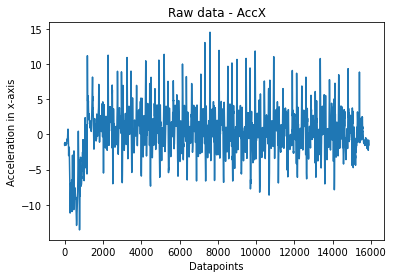

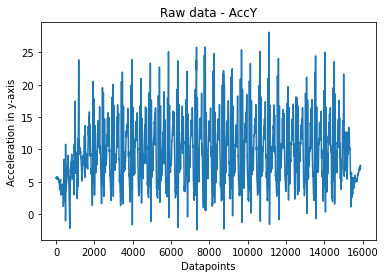

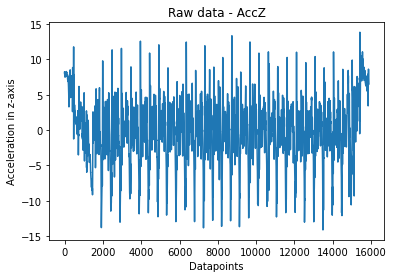

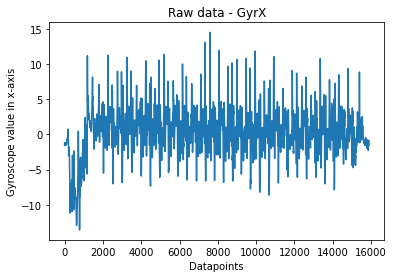

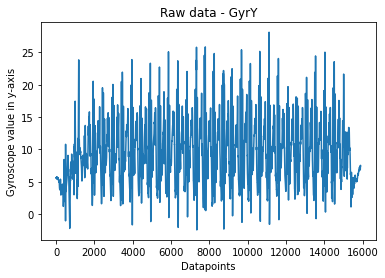

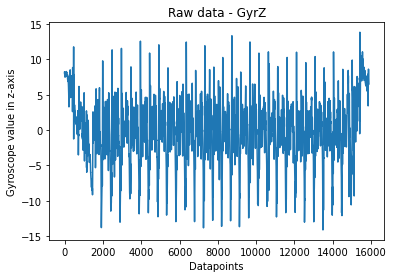

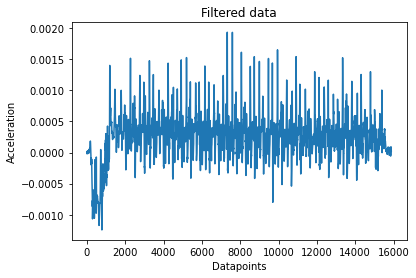

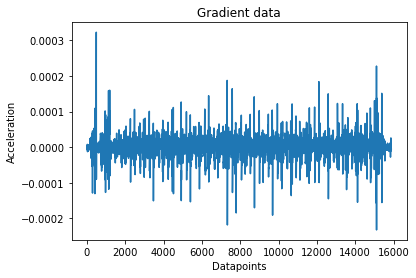

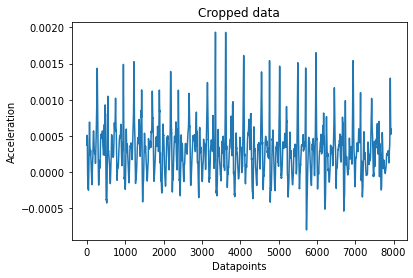

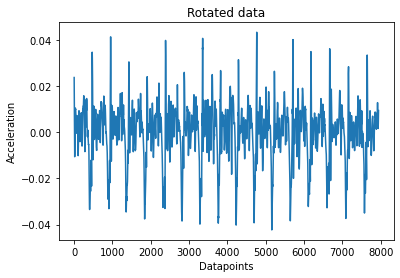

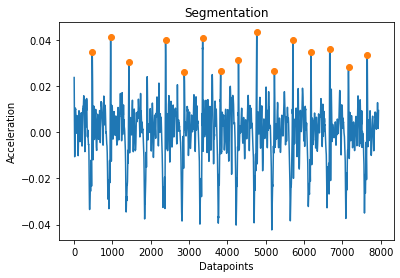

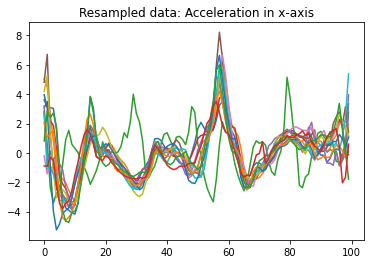

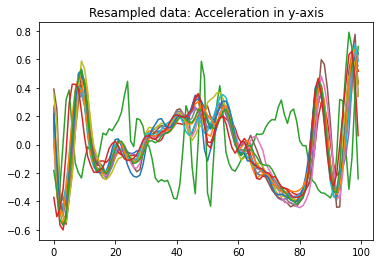

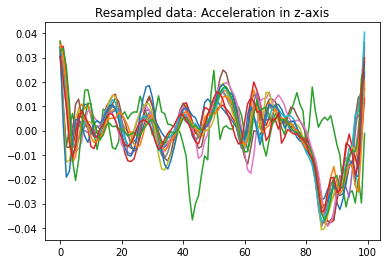

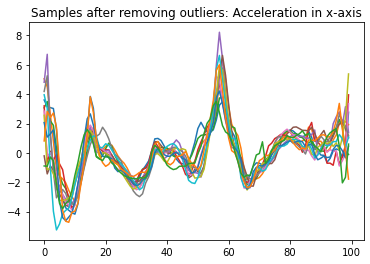

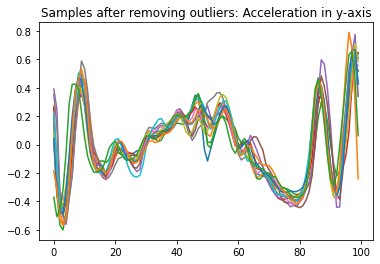

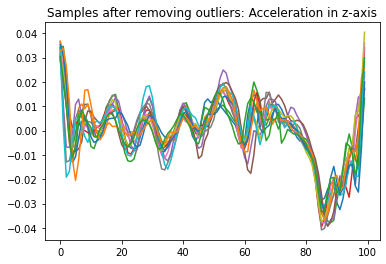

In [16]:
#Select a subject to plot the graphs
i = 34
k = "normal"
j = "01"
file1 = os.getcwd()+'/data/Smartphone3/subject{}'.format(i)+'_'+k+j+'/Accelerometer.csv'
file2 = os.getcwd()+'/data/Smartphone3/subject{}'.format(i)+'_'+k+j+'/Accelerometer.csv'

plotter(file1,file2)

# 2. Neural Network
Before passing the data to the neural network, it must be normalized. We have normalized such that the value lies between 0.1 and 0.9.

In [17]:
def normalization(df,age_flag=False):
    df[:,:,5] = 0.1* np.ones_like(df[:,:,5])   #Since all the element of gyroscope z is zero
    for i in range(5):
        a = np.copy(df[:,:,i])
        df[:,:,i] = 0.1 * np.ones_like(a) + 0.8 * (a - np.min(a)* np.ones_like(a))/(np.max(a)-np.min(a))
    # Sex value is either 0 or 1, so there is no need of normalization. But for age the normalization is required
    if(age_flag == True):     
        a = np.copy(df[:,:,6])
        df[:,:,6] = 0.1 * np.ones_like(a) + 0.8 * (a - np.min(a)* np.ones_like(a))/(np.max(a)-np.min(a))
    return df

In [18]:
# Neural network based on sex 
# Function to create the NN model, train it and the evaluate it. Input parameters are training dataset and test dataset
#Number of input neuron = 700, hidden layer= 3, neuron per hidden layer = [7,6,5], output neuron = 1


def NN_sex(trains,trainl,tests,testl,epoch):
    
    model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(100,7)),            #Input layer
    tf.keras.layers.Dense(7, activation ='sigmoid'),         #Hidden layer 1
    tf.keras.layers.Dense(6, activation ='sigmoid'),         #Hidden layer 2
    tf.keras.layers.Dense(5, activation ='sigmoid'),         #Hidden layer 3
    tf.keras.layers.Dense(1, activation ='sigmoid')          #Output layer
    ])

    model.compile(optimizer = 'adam',
                 loss = 'binary_crossentropy',
                 metrics = ['accuracy'])

    model.fit(trains, trainl, epochs = epoch, shuffle=True, batch_size=5);
    
    loss, accuracy = model.evaluate(tests, testl, verbose=0);

    print('Loss=', loss)
    print('accuracy=', accuracy)
    

In [19]:
def total_param(l=[]):
    s=0
    for i in range(len(l)-1):
        s=s+l[i]*l[i+1]+l[i+1]
        return s

In [20]:
total_param([700,7,6,5,1]) 

4907

In [21]:
# Neural network based on age
# Function to create the NN model, train it and the evaluate it. Input parameters are training dataset and test dataset
#Number of input neuron = 700, hidden layer= 3, neuron per hidden layer = [7,6,5], output neuron = 1

def NN_age(trains,trainl,tests,testl,epoch):
    
    model1 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(100,7)),
    tf.keras.layers.Dense(7, activation ='tanh'),
    tf.keras.layers.Dense(6, activation ='tanh'),
    tf.keras.layers.Dense(5, activation ='sigmoid'),
    tf.keras.layers.Dense(1, activation ='sigmoid')
    ])

    model1.compile(optimizer = 'adam',
                 loss = 'binary_crossentropy',
                 metrics = ['accuracy'])

    model1.fit(trains, trainl, epochs = epoch, shuffle=True, batch_size=5);
    
    loss, accuracy = model1.evaluate(tests, testl, verbose=0);

    print('Loss=', loss)
    print('accuracy=', accuracy)

In [22]:
def total_param(l=[]):
    s=0
    for i in range(len(l)-1):
        s=s+l[i]*l[i+1]+l[i+1]
        return s

In [23]:
total_param([700,7,6,5,1]) 

4907

# 3. Cross validation
Five fold subject wise cross validation is performed. The list subset contains the input data in five sets. We loop over the index of dataset. We take that set as the test dataset and concatenate other input data into training dataset. Normalization is done and then the trainng and test dataset are passed to the neural network.

In [24]:
#Cross validation with sex
epoch = 3
avg_acc = 0.0
max_acc = 0.0
for epoch in range(epoch):
    start_time = time.time()
    
    for i in range(0,5):
        trainlist = [0,1,2,3,4]
        trainlist.remove(i)
        trainset = np.concatenate((subset[trainlist[0]],subset[trainlist[1]],subset[trainlist[2]],subset[trainlist[3]]),axis=0)
        trainlabel = np.concatenate((label[trainlist[0]],label[trainlist[1]],label[trainlist[2]],label[trainlist[3]]),axis=0)
        testset = np.copy(subset[i])
        testlabel = np.copy(label[i])
        trainset = normalization(trainset)
        testset = normalization(testset)
        NN_sex(trainset,trainlabel,testset,testlabel,epoch) 
        
        print("Time taken: %.2fs" % (time.time() - start_time))  

Loss= 0.7015900611877441
accuracy= 0.43001842498779297
Time taken: 0.45s
Loss= 0.7254478931427002
accuracy= 0.5123456716537476
Time taken: 0.79s
Loss= 0.6936620473861694
accuracy= 0.43412908911705017
Time taken: 1.22s
Loss= 0.8112428188323975
accuracy= 0.5246478915214539
Time taken: 1.58s
Loss= 0.7191193699836731
accuracy= 0.3695976138114929
Time taken: 1.97s
693/693 [==============================] - 1s 743us/step - loss: 0.6874 - accuracy: 0.5557
Loss= 0.684515655040741
accuracy= 0.569981575012207
Time taken: 1.35s
748/748 [==============================] - 1s 710us/step - loss: 0.6845 - accuracy: 0.5647
Loss= 0.6976115703582764
accuracy= 0.5123456716537476
Time taken: 2.47s
684/684 [==============================] - 0s 673us/step - loss: 0.6872 - accuracy: 0.5569
Loss= 0.684539794921875
accuracy= 0.5658708810806274
Time taken: 3.60s
740/740 [==============================] - 0s 628us/step - loss: 0.6848 - accuracy: 0.5671
Loss= 0.6975526809692383
accuracy= 0.5246478915214539
Time ta

In [25]:
#Cross validation with age
epoch = 3
avg_acc = 0.0
max_acc = 0.0
for epoch in range(epoch):
    start_time = time.time()

    for i in range(0,5):
        trainlist = [0,1,2,3,4]
        trainlist.remove(i)
        trainset_age = np.concatenate((subset_age[trainlist[0]],subset_age[trainlist[1]],subset_age[trainlist[2]],subset_age[trainlist[3]]),axis=0)
        trainlabel_age = np.concatenate((label[trainlist[0]],label[trainlist[1]],label[trainlist[2]],label[trainlist[3]]),axis=0)
        testset_age = np.copy(subset_age[i])
        testlabel_age = np.copy(label[i])
        
        trainset_age = normalization(np.copy(trainset_age),age_flag=True)
        testset_age = normalization(np.copy(testset_age),age_flag=True)
                                     
        NN_age(trainset_age,trainlabel_age,testset_age,testlabel_age,epoch)
        
        print("Time taken: %.2fs" % (time.time() - start_time))                            

Loss= 0.6834138035774231
accuracy= 0.569981575012207
Time taken: 0.39s
Loss= 0.7523398399353027
accuracy= 0.48765432834625244
Time taken: 1.03s
Loss= 0.6838903427124023
accuracy= 0.5658708810806274
Time taken: 1.50s
Loss= 0.7223449349403381
accuracy= 0.5246478915214539
Time taken: 1.88s
Loss= 0.6593114137649536
accuracy= 0.6304023861885071
Time taken: 2.31s
693/693 [==============================] - 0s 648us/step - loss: 0.6875 - accuracy: 0.5557
Loss= 0.6842663288116455
accuracy= 0.569981575012207
Time taken: 1.13s
748/748 [==============================] - 1s 701us/step - loss: 0.6873 - accuracy: 0.5524
Loss= 0.6979925632476807
accuracy= 0.5123456716537476
Time taken: 2.31s
684/684 [==============================] - 0s 638us/step - loss: 0.6916 - accuracy: 0.5367
Loss= 0.6849207878112793
accuracy= 0.5658708810806274
Time taken: 3.62s
740/740 [==============================] - 1s 784us/step - loss: 0.6856 - accuracy: 0.5641
Loss= 0.6970705389976501
accuracy= 0.5246478915214539
Time ta